# 0.0 Introduction <a name="introduction"></a>

TODO

## 0.1 Table of contents
- [1.0 Import Dataset](#section1)
    - [1.1 Data description](#section11)
- [2.0 Exploratory Data Analysis](#section2)
    - [2.1 User activity](#section21)
    - [2.2 Reposts](#section22)
    - [2.3 Most liked authors](#section23)
    - [2.4 Most active authors](#section24)
    - [2.5 Best posts per year](#section25)
    - [2.6 EDA Summary](#section26)
- [3.0 Create New Text Features](#section3)
    - [3.1 Translate to english](#section31)
    - [3.1 Sentiment](#section32)
    - [3.2 Title key words](#section33)
- [4.0 Sentiment Over Time](#section4)
    - [4.1 Little Google](#section41)
    - [4.2 Most Frequent Words](#section42)
    - [4.3 Sentiment over time plots](#section43)
- [5.0 Conclusion](#section5)
- [6.0 Appendix](#section6)
    - [A: SpaCy Language Detection](#sectionA)
    - [B: Example Regexp Cases](#sectionB)
    - [C: Author Activity](#sectionC)

## 0.2 Dependencies

TODO

# 1.0 Import Dataset <a name="section1"></a>

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', None)
plt.style.use('seaborn-pastel')
sns.set_palette("pastel")

In [2]:
df = pd.read_csv('Eluvio_DS_Challenge.csv')
df['date_created'] = pd.to_datetime(df['date_created'])
df.head(5)

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   time_created  509236 non-null  int64         
 1   date_created  509236 non-null  datetime64[ns]
 2   up_votes      509236 non-null  int64         
 3   down_votes    509236 non-null  int64         
 4   title         509236 non-null  object        
 5   over_18       509236 non-null  bool          
 6   author        509236 non-null  object        
 7   category      509236 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(3), object(3)
memory usage: 27.7+ MB


## 1.1 Data description <a name="section11"></a>

In [5]:
print(f"There are {df.shape[0]} observations and {df.shape[1]} features in this dataset.")

There are 509236 observations and 8 features in this dataset.


In [6]:
fd = df.date_created.iloc[0]  # First Date
ld = df.date_created.iloc[-1] # Last Date

print(f'First date - {fd.month}/{fd.day}/{fd.year}')
print(f'End date - {ld.month}/{ld.day}/{ld.year}')

First date - 1/25/2008
End date - 11/22/2016


In [7]:
df.nunique(axis=0)

time_created    508329
date_created      3223
up_votes          5782
down_votes           1
title           500720
over_18              2
author           85838
category             1
dtype: int64

In [8]:
df.down_votes.unique()

array([0])

In [9]:
df.category.unique()

array(['worldnews'], dtype=object)

**Observations:**

The dataset seems to contain reddit data from the thread `r/worldnews` between **Janurary 25th, 2008** and **November 22nd, 2016**. It contains **509,236** rows and **8 columns**:

- time_created (unix timestamp),
- date_created (YYYY-MM-DD),
- up_votes,
- down_votes,
- title,
- over_18 (T/F),
- author,
- category.

From the prelimiary search, we see that there are no `null` values in this dataset (`df.info()`), which makes our lives easier! It looks like there are no columns that can act as an index, since no one column has all unique values. That being said, it was interesting to see that the `title` column has reposts (500,720 unique titles or ~7700 reposts). Lastly, it looks like of the 8 columns, `down_votes` and `worldnews` only have one unique item - `0` and `worldnews` respectively - meaning that these features don't provide us any useful information. Moreover, the `time_created` column (unix timestamp) provides more specific time information, but the `date_created` should be sufficient for my analysis. Therefore, these three columns were removed. 

Of all the attributes, I would say the titles provide the most meaningful information. However, it is difficult to analyze raw sentences, so some text preprocessing will need to be done before we can analyze the titles further (see section 3.0).

In [10]:
df = df[['date_created', 'title', 'author', 'over_18', 'up_votes']]
df.head(5)

,date_created,title,author,over_18,up_votes
0,2008-01-25,Scores killed in Pakistan clashes,polar,False,3
1,2008-01-25,Japan resumes refuelling mission,polar,False,2
2,2008-01-25,US presses Egypt on Gaza border,polar,False,3
3,2008-01-25,Jump-start economy: Give health care to all,fadi420,False,1
4,2008-01-25,Council of Europe bashes EU&UN terror blacklist,mhermans,False,4


# 2.0 Exploratory Data Analysis <a name="section2"></a>

Before beginning the natural language processing portion of this report, I will first do some digging into the data to better understand the nature of the data and find any edge-cases that I should know about. Since this section contains several sub-parts, I will list the the sections and a short summary of what to expect in each section.

- **User activity:** activity of users (by upvotes and number of posts) throughout the years
- **Reposts:** delving deeper to understand what posts were reposted
- **Most liked authors:** authors with the highest cumulative upvotes
- **Most active authors:** authors who posted the most
- **Best posts per year:** the most liked post each year
- **EDA Summary**

I will make observations throughout this section and summarize all findings in section 2.9.

## 2.1 User activity <a name="section21"></a>

### 2.1.1 Overall

<AxesSubplot:xlabel='date_created'>

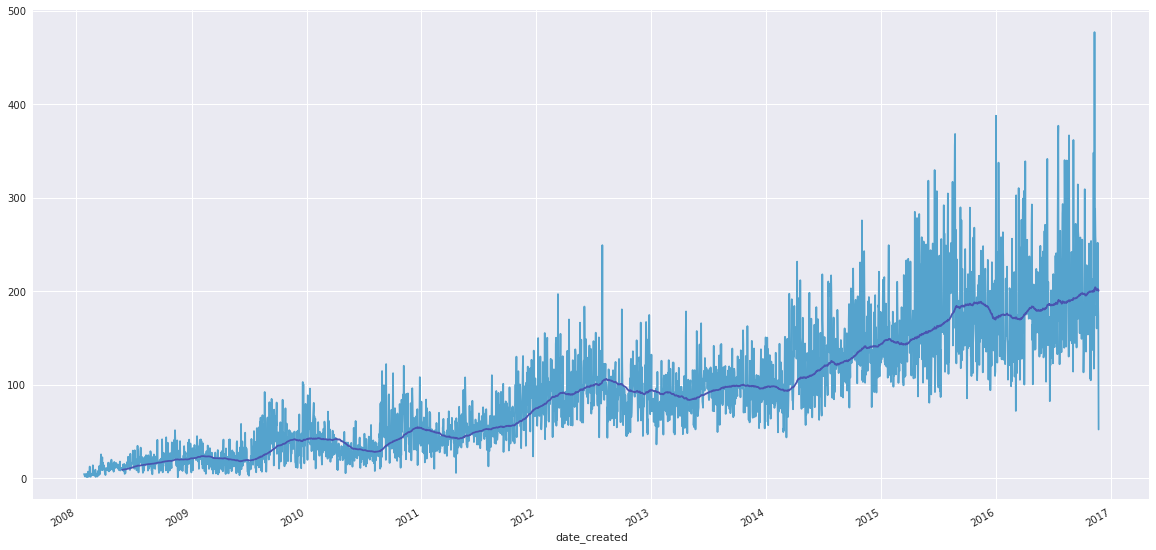

In [111]:
df.groupby('date_created')['up_votes'].mean().plot()
df.groupby('date_created')['up_votes'].mean().rolling(window=120).mean().plot(figsize= (20, 10))

## 2.1.2 By year, month

2008 had an average of 1875.42 posts.
2010 had an average of 1942.75 posts.
2012 had an average of 3553.58 posts.
2013 had an average of 7352.58 posts.
2014 had an average of 7669.17 posts.
2016 had an average of 7444.73 posts.


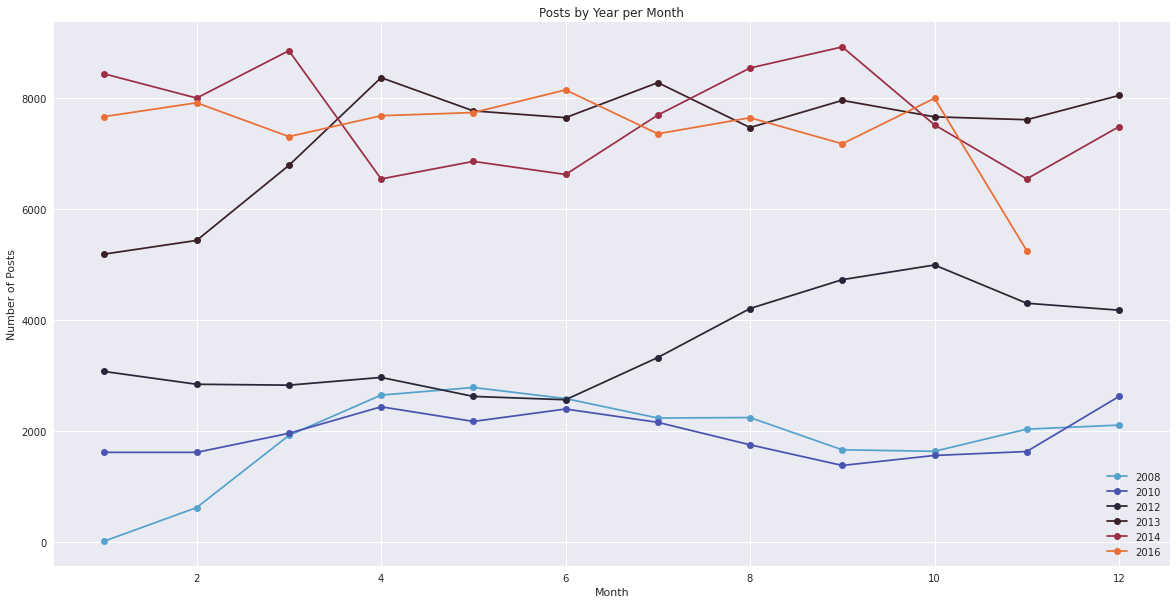

In [110]:
years = [2008, 2010, 2012, 2013, 2014, 2016]

for year in years:
    yr_slice = df.loc[df.date_created.dt.year==year]
    grp_month = yr_slice.groupby([yr_slice.date_created.dt.month])['title'].count()
    month_ts = pd.Series(grp_month)
    ax = month_ts.plot(kind='line', figsize=(20,10), style='o-',legend=True, label=year)
    print(f'{year} had an average of {month_ts.mean():.2f} posts.')

ax.set_xlabel("Month")
ax.set_ylabel("Number of Posts")
ax.set_title("Posts by Year per Month")
plt.show()

**Observations:** I left out the years 2009, 2011, and 2015 because it made the graph too cluttered, but the overall trends still stand: there seems to be an increase in reddit posts starting from mid-2012.
- Overall, there is a positive trend in reddit users on `r/worldnews`.
- Between **2008-2012** there were about **2,500** posts per year (bottom three lines).
- Between **2013-2016** there were about **7,500** posts per year (top three lines).
- There seemed to be an **increased volume of posts and activity** beginning in late 2012.

## 2.2 Most reposted titles, ordered by upvotes <a name="section22"></a>

In [13]:
most_reposted = df.groupby(['title'])\
    .agg({'up_votes':'sum', 'author':'count'})\
    .sort_values(by=['author', 'up_votes'], ascending = False)

most_reposted

,up_votes,author
title,,
Brutality of Syrian Rebels Posing Dilemma in West,154,6
Hungarian nationalist TV camera operator filmed kicking refugee children,2635,5
South Korea reveals it has a plan to assassinate Kim Jong Un,494,5
Putin nominated for Nobel Peace Prize,295,5
Swiss tourist gang-raped in India,211,5
...,...,...
◄ OLDER NEWER ► Iran denies IAEA access to suspect military site,0,1
《you and me》2008 Olympic Opening Ceremony theme song lyrics,0,1
何謂標靶治療？ - 癌症 腫瘤 - Yahoo!奇摩部落格,0,1


In [14]:
most_reposted_title = most_reposted.iloc[0].name

df[df['title'] == most_reposted_title]\
    .sort_values(by=['date_created'], ascending = False)

,date_created,title,author,over_18,up_votes
210805,2013-09-06,Brutality of Syrian Rebels Posing Dilemma in West,GreyMatter22,False,31
210806,2013-09-06,Brutality of Syrian Rebels Posing Dilemma in West,BillTowne,False,57
210607,2013-09-05,Brutality of Syrian Rebels Posing Dilemma in West,Jewpiter,False,19
210632,2013-09-05,Brutality of Syrian Rebels Posing Dilemma in West,0x0E,False,28
210685,2013-09-05,Brutality of Syrian Rebels Posing Dilemma in West,emr1028,False,7
210720,2013-09-05,Brutality of Syrian Rebels Posing Dilemma in West,erowidtrance,False,12


**Observations:**
- There seem to be a relatively small number of reposts per news article (max 6 reposts for one topic).
- I confirmed that they all are reposts and reference the same [NYTimes article](https://www.nytimes.com/2013/09/05/world/middleeast/brutality-of-syrian-rebels-pose-dilemma-in-west.html).
- The two authors who reposted the article a day after everyone else (`Greymater22` and `BillTowne`) had more upvotes than the rest (I found this funny).
- There seem to be non-English titles (see [Appendix A](#sectionA)) and odd-text in this dataset. This might might maker it harder to clean the text for text analysis.

## 2.3 Most liked authors <a name="section23"></a>

In [15]:
author_activity = df.groupby(['author'])\
    .agg({'up_votes':'sum', 'title':'count'})

In [16]:
most_liked_authors = author_activity\
    .sort_values(by='up_votes', ascending = False)\
    .head(10)

most_liked_authors.reset_index(drop=False, inplace=True)

Text(0.5, 1.0, 'Most up-voted authors')

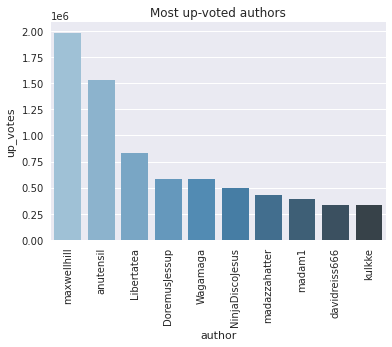

In [114]:
ax = sns.barplot(x='author', 
                 y='up_votes', 
                 data=most_liked_authors,
                 palette='Blues_d')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Most up-voted authors')

In [18]:
print(f'`maxwellhill`: {most_liked_authors.iloc[0].up_votes} upvotes.')
print(f'`anutensil`:   {most_liked_authors.iloc[1].up_votes} upvotes.')

`maxwellhill`: 1985416 upvotes.
`anutensil`:   1531544 upvotes.


**Observations:**
- The most liked author is `maxwellhill` with 1,985,416 upvotes over 4,023 posts.
- The second most liked author is `anutensil` with 1,531,544 upvotes over 5,730 posts.
- It would be interesting to see what topics tend to get more upvotes.

## 2.4 Most active authors, ordered by upvotes <a name="section24"></a>

In [19]:
most_active_authors = author_activity\
    .sort_values(by=['title', 'up_votes'], ascending = False)\
    .head(10)

most_active_authors.reset_index(drop=False, inplace=True)

Text(0.5, 1.0, 'Number of posts per authors')

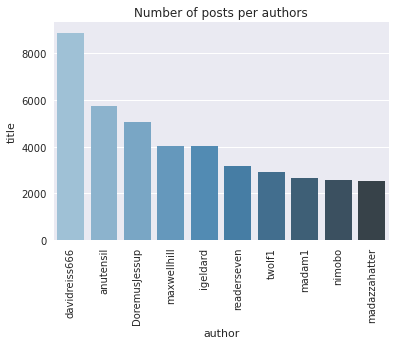

In [115]:
ax = sns.barplot(x='author', 
                 y='title', 
                 data=most_active_authors,
                 palette='Blues_d')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Number of posts per authors')

**Observations:**
- Although `maxwellhill` is the most liked author, `davidreiss666` has the most number of posts with only 338,306 upvotes. So it seems a larger volume of posts doesn't correlate to more likes.

## 2.5 Best posts per year <a name="section25"></a>

In [21]:
df['year_created'] = df['date_created'].dt.year

In [22]:
df_title = df.groupby(['year_created', 'title'])\
    .agg({'up_votes':'sum', 'author':'count'})\
    .reset_index().set_index('year_created')

df = df.drop(['year_created'], axis=1)

df_year_wise_maxupvotes = df_title.groupby(['year_created'])\
    .agg({'up_votes':'max'})\
    .reset_index().set_index('year_created')

merged_df = df_title.merge(df_year_wise_maxupvotes, on=['year_created', 'up_votes'])\
    .sort_values(by=['year_created'], ascending = False)

merged_df

,title,up_votes,author
year_created,,,
2016,"2.6 terabyte leak of Panamanian shell company data reveals how a global industry led by major banks, legal firms, and asset management companies secretly manages the estates of politicians, Fifa officials, fraudsters and drug smugglers, celebrities and professional athletes.",13244,1
2015,"A biotech startup has managed to 3-D print fake rhino horns that carry the same genetic fingerprint as the actual horn. The company plans to flood Chinese rhino horn market at one-eighth of the price of the original, undercutting the price poachers can get and forcing them out eventually.",21253,1
2014,"NASA officially announces Manned Mars Mission, test launch will begin tomorrow testing orbiter.",9303,1
2013,"What we have... is... concrete proof of U.S.-based... companies participating with the NSA in wholesale surveillance on us, the rest of the world, the non-American, you and me, Mikko Hypponen, chief research officer at Finnish software security firm F-Secure.",10159,1
2012,"Canada creates $5,000 cap on liability for file sharing lawsuits",7457,1
2011,North Korea Leader Kim-Jong Il has died,4142,1
2010,"Dear World, The Chinese government stole intellectual property from us and others. The censorship is crazy over there and we are seriously considering ceasing our Chinese operation. - signed google.",3187,1
2009,How do I know China wrecked the Copenhagen deal? I was in the room.,3392,1
2008,"Today Israel takes down an entire apt building of civilians to kill the family of one man. In Canada, we call that terrorism.",1856,1


In [23]:
avg_upvotes = merged_df.up_votes.mean()
print(f'Among the most liked posts, there is an average upvote count of {avg_upvotes:.0f}.')

Among the most liked posts, there is an average upvote count of 8221.


**Observations:**
- The most liked content has on average 8,221 upvotes.
- We see here there is a similar trend to what we saw in section 2.1.2, where there is a noticeable increase in number of upvotes starting in the year 2012 (when user activity began to increase).
- These topics seem to be about politics, fraud, surveillance, and science.

## 2.6 Summary <a name="section26"></a>

Overall, we see an increased volume in reddit user beginning around 2012. Prior to 2012, there was an average of about 2,500 posts per year, while after 2012 there was an average of about 7,500 posts per year. The number-one liked posts was about a 3D printed rhino horn, which had 21,253 upvotes in 2015 (I think I remember reading about this). However, the majority of the top most liked articles seemed to be about politics and violence. About 7,700 articles were reposts at most 6 times. The most liked author is `maxwellhill`, while the most active author is `davidreiss666`. 

TODO: What to do with insight

# 3.0 Create New Text Features <a name="section3"></a>

In this section, I will find the sentiment and create key words for each title. Sentiment is an important feature that provides more insight for each title. Key words will make it easier to search for specific titles that contain search words (ex. 'US', 'recession', 'health', etc.). **A dataset with all features can be downloaded in section 4.0.**

In [24]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import itertools
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
''' ONLY NEED TO DOWNLOAD PACKAGES ONCE '''
nltk.download(['wordnet','stopwords','vader_lexicon','punkt'])

## 3.1 Sentiment <a name="section32"></a>

The first feature I will add to the dataset is sentiment. Sentiment analysis can be done using the ___ package from `nltk`. This pre-trained model can look at sentences and determine a compound score, where a positive sentiment is a score of $[0.05, 1]$,  a negative sentiment is a score of $[-1, -0.05]$, and a neutral sentiment a score of $(-0.05, 0.05)$, where brackets are inclusive and parentheses are non-inclusive ([source](https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/)).

To find the sentiment for each title, I will pass each title through the `Sentiment Intensity Analyzer` object. I will only store the compound score as it provides all sentiment information in one value.  

In [25]:
# create nltk sentiment analyzer object 
sid = SentimentIntensityAnalyzer() 

# find (compound) title sentiment using polarity_scores
%time sentiment = [sid.polarity_scores(title)['compound'] for title in df.title]  

CPU times: user 1min 29s, sys: 5.31 s, total: 1min 34s
Wall time: 1min 34s


In [26]:
# append data to dataframe
df['compound'] = sentiment
df.head()

,date_created,title,author,over_18,up_votes,compound
0,2008-01-25,Scores killed in Pakistan clashes,polar,False,3,-0.6705
1,2008-01-25,Japan resumes refuelling mission,polar,False,2,0.0000
2,2008-01-25,US presses Egypt on Gaza border,polar,False,3,0.0000
3,2008-01-25,Jump-start economy: Give health care to all,fadi420,False,1,0.4939
4,2008-01-25,Council of Europe bashes EU&UN terror blacklist,mhermans,False,4,-0.5267


## 3.2 Title key words <a name="section33"></a>

In [27]:
# Step 0: get stopwords
stopwords = stopwords.words('english') + list(string.punctuation)
stopwords = stopwords + ['”', '“', '’', '‘', 'nsfw', 'say', 'has', 'new']

In [28]:
# Step 1: create regexp tokenizer
# SEE EXAMPLE CASES IN APPENDIX B
re1 = r"\w+"      # words only
re2 = r"\$[,\d]*" # dollars
re3 = r"#[\w+]*"  # hashtags
re4 = r"\/[r]/"   # subreddits

generic_re = re.compile("(%s|%s|%s|%s)" % (re1, re2, re3, re4))

In [29]:
# Step 2: find key words (tokenize and lemmatize titles)
tkzr = nltk.RegexpTokenizer(generic_re)
ltzr = WordNetLemmatizer()

def find_key_words(df_titles):    
    # remove dots (ex U.S. -> US) and tokenize
    tokens = df_titles.replace(r'\.','',regex=True).map(tkzr.tokenize)
    
    # translate to english - googletrans.Translate
    ## TODO
    
    # remove stopwords
    for i, title in enumerate(tokens):
        tokens[i] = [w.lower() for w in title if ltzr.lemmatize(w).lower() not in stopwords]
        
    return tokens

In [31]:
# find key words
%time key_words = find_key_words(df.title)

CPU times: user 53.8 s, sys: 703 ms, total: 54.5 s
Wall time: 54.5 s


In [32]:
# append data to dataframe
df['key_words'] = key_words
df.head()

,date_created,title,author,over_18,up_votes,compound,key_words
0,2008-01-25,Scores killed in Pakistan clashes,polar,False,3,-0.6705,"[scores, killed, pakistan, clashes]"
1,2008-01-25,Japan resumes refuelling mission,polar,False,2,0.0000,"[japan, resumes, refuelling, mission]"
2,2008-01-25,US presses Egypt on Gaza border,polar,False,3,0.0000,"[us, presses, egypt, gaza, border]"
3,2008-01-25,Jump-start economy: Give health care to all,fadi420,False,1,0.4939,"[jump, start, economy, give, health, care]"
4,2008-01-25,Council of Europe bashes EU&UN terror blacklist,mhermans,False,4,-0.5267,"[council, europe, bashes, eu, un, terror, blacklist]"


In [63]:
# save final dataset
df.to_csv('worldnews.csv')

# 4.0 Sentiment Over Time <a name="section4"></a>

In [431]:
'''CHECKPOINT: LOAD SAVED CSV'''
df = pd.read_csv('worldnews.csv').drop('Unnamed: 0', axis=1)
df['date_created'] = pd.to_datetime(df['date_created'])
df.reset_index(drop=True, inplace=True)

key_words = df.key_words

## 4.1 Little Google <a name="section41"></a>

In [48]:
def little_google(x):
    x_r = re.sub(r'\.','',x) # remove punctuation
    x_l = x_r.lower()        # lower
    return df.loc[key_words.map(lambda sent: x_l in sent).values]

In [49]:
# example 1: U.S.
little_google('U.S.').head(5)

,date_created,title,author,over_18,up_votes,compound,key_words
2,2008-01-25,US presses Egypt on Gaza border,polar,False,3,0.0000,"[us, presses, egypt, gaza, border]"
9,2008-01-29,US plans for missile shields in Polish town met with resistance [video],JoeyRamone63,False,3,0.0000,"[us, plans, missile, shields, polish, town, met, resistance, video]"
11,2008-01-30,Top US Envoy: Violence In Kenya Is Ethnic Cleansing,smacfarl,False,9,-0.5106,"[top, us, envoy, violence, kenya, ethnic, cleansing]"
25,2008-02-01,Taliban threatens US/NATO supply lines in Pakistan [video news story],JoeyRamone63,False,3,-0.3818,"[taliban, threatens, us, nato, supply, lines, pakistan, video, news, story]"
49,2008-02-06,US says al-Qaida in Iraq using children,dizzle67,False,7,0.0000,"[us, al, qaida, iraq, using, children]"


In [50]:
# example 2: /r/
little_google('/r/').head()

,date_created,title,author,over_18,up_votes,compound,key_words
5510,2008-05-04,"Dear Redditors: Don t pollute the worldnews subreddit. Please submit US politics articles to /r/politics, and US news to /r/reddit.com.",sysreq2,False,6,0.1531,"[dear, redditors, pollute, worldnews, subreddit, please, submit, us, politics, articles, /r/, politics, us, news, /r/, redditcom]"
23949,2009-01-15,I m submitting this video to /r/worldnews because of the ongoing Gaza situation. This just caused tears to roll down my cheeks. (h/t pinxox),ropers,False,15,-0.2263,"[submitting, video, /r/, worldnews, ongoing, gaza, situation, caused, tears, roll, cheeks, h, pinxox]"
31104,2009-03-31,"[New Reddit]: /r/Sudan: Shine some light on this crisis in which 400,000 people may have already died.",glengyron,False,0,-0.8582,"[reddit, /r/, sudan, shine, light, crisis, 400, 000, people, may, already, died]"
37219,2009-06-21,I suggest renaming this /r/ to: Iran and one or two other world news.,bojancho,False,0,0.0000,"[suggest, renaming, /r/, iran, one, two, world, news]"
46986,2009-12-16,"When posting in /r/worldnews, identify the country the news is about in your submission headline somehow.",hans1193,False,3,0.0000,"[posting, /r/, worldnews, identify, country, news, submission, headline, somehow]"


In [51]:
# example 3: #syria
little_google('#syria').head()

,date_created,title,author,over_18,up_votes,compound,key_words
193335,2013-06-29,New video of ‘ #Islamist ’ public beheadings of ‘ #Assad loyalists’ surfaces in #Syria (GRAPHIC CONTENT),aleksanderkalinin,False,9,0.0000,"[video, #islamist, public, beheadings, #assad, loyalists, surfaces, #syria, graphic, content]"
341421,2015-02-04,Government airstrikes kill dozens across #Syria,Puffin_fan,False,0,-0.6908,"[government, airstrikes, kill, dozens, across, #syria]"
368799,2015-05-19,Turkey-Clinton sets up secret #ISIS rebel base with S.Arabia and Qatar #Syria #SAA,avgerinosx,False,1,-0.1531,"[turkey, clinton, sets, secret, #isis, rebel, base, sarabia, qatar, #syria, #saa]"


## Most Frequent Words <a name="section42"></a>

### 4.1.1 For entire dataset

In [34]:
def wordcloud(tokens, title=''):
    wordcloud = WordCloud(background_color='white', width=3000, height=2500)\
        .generate(' '.join(tokens))

    # Display the generated image:
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

In [40]:
# concatenate all tokens
all_tokens = list(itertools.chain.from_iterable(key_words))

print(f'There are a total of {len(all_tokens)} key words')

There are a total of 5228312 key words


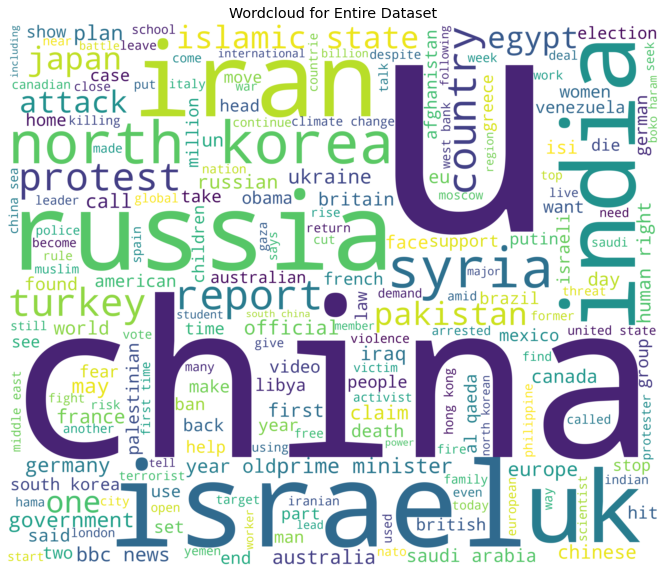

In [36]:
title = "Wordcloud for Entire Dataset"
wordcloud(all_tokens, title)

### 4.1.2 For most liked author

In [37]:
liked_author_tokens = df[df['author'] == most_liked_authors.iloc[0].author]\
    .loc[:,'key_words']\
    .values.tolist()

liked_author_tokens = list(itertools.chain.from_iterable(liked_author_tokens))

print(f'The most liked author is `{most_liked_authors.iloc[0].author}` and had a total of {len(liked_author_tokens)} key words')

The most liked author is `maxwellhill` and had a total of 64341 key words


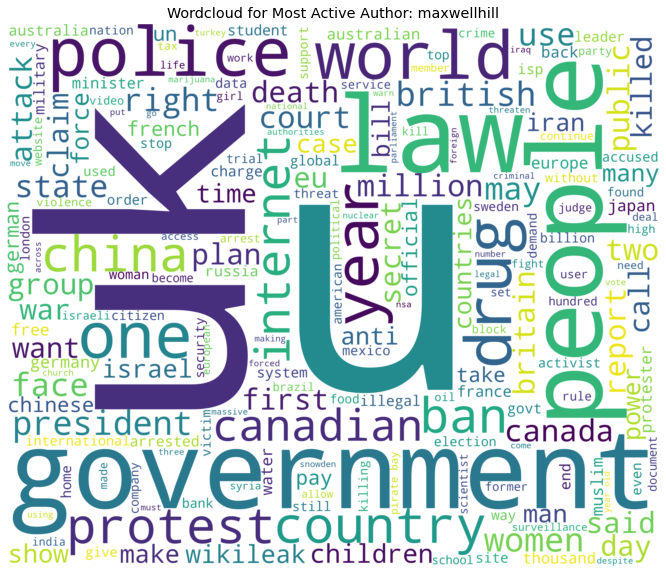

In [38]:
title = "Wordcloud for Most Active Author: maxwellhill"
wordcloud(liked_author_tokens, title)

## 4.3 Sentiment over time plots <a name="section43"></a>

In [122]:
LINECOLOR_CYCLE = ['bo-','go-','ro-','co-','mo-','yo-','ko-']

def plot_sentiment_pipeline(topics, col='compound', title=''):
    
    dfs = []
    for topic in topics:
        if topic == 'baseline':
            temp_df = df.groupby(df.date_created.dt.year).agg({col:'mean'})
            temp_df.reset_index(drop=False, inplace=True)
            dfs.append(temp_df)
        else:
            temp_df = little_google(topic)[['date_created',col]].groupby(df.date_created.dt.year).agg({col:'mean'})
            temp_df.reset_index(drop=False, inplace=True)
            dfs.append(temp_df)
    
    fig = plt.figure(figsize=(15,10))
    for i,frame in enumerate(dfs):
        if topics[i] == 'baseline':
            plt.plot(frame['date_created'], frame[col], 'k--', linewidth=6, label=topics[i])
        else:
            plt.plot(frame['date_created'], frame[col], LINECOLOR_CYCLE[i], label=topics[i])
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Compound Sentiment")
    plt.title(title)

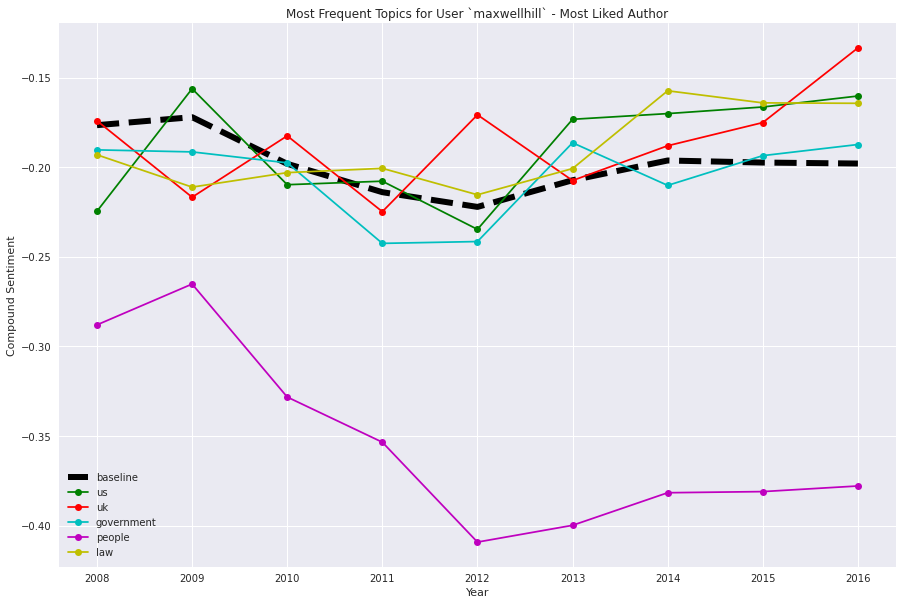

In [86]:
topics = ['baseline','us','uk','government','people','law']
title = 'Most Frequent Topics for User `maxwellhill` - Most Liked Author'
plot_sentiment_pipeline(topics, title=title)

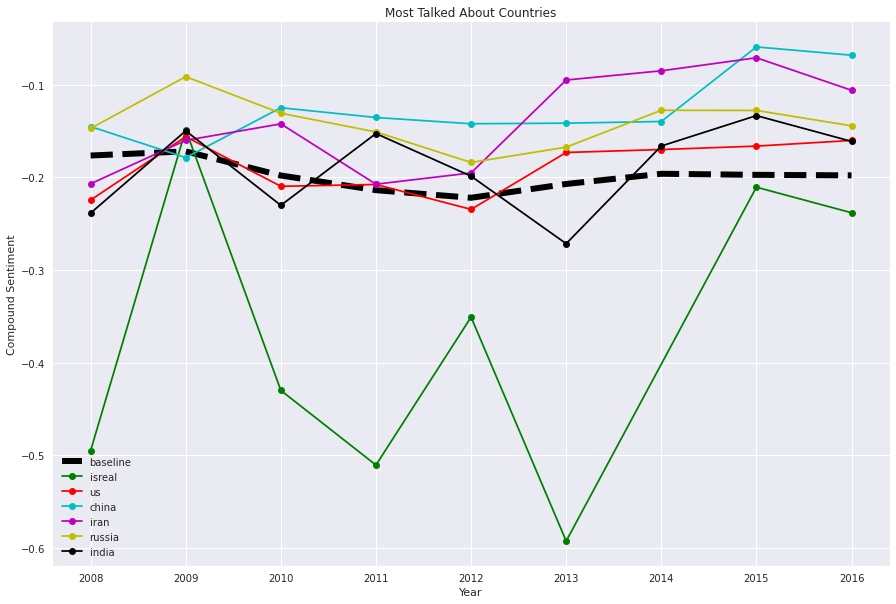

In [87]:
topics = ['baseline','isreal','us','china','iran','russia','india']
title = 'Most Talked About Countries'
plot_sentiment_pipeline(topics, title=title)

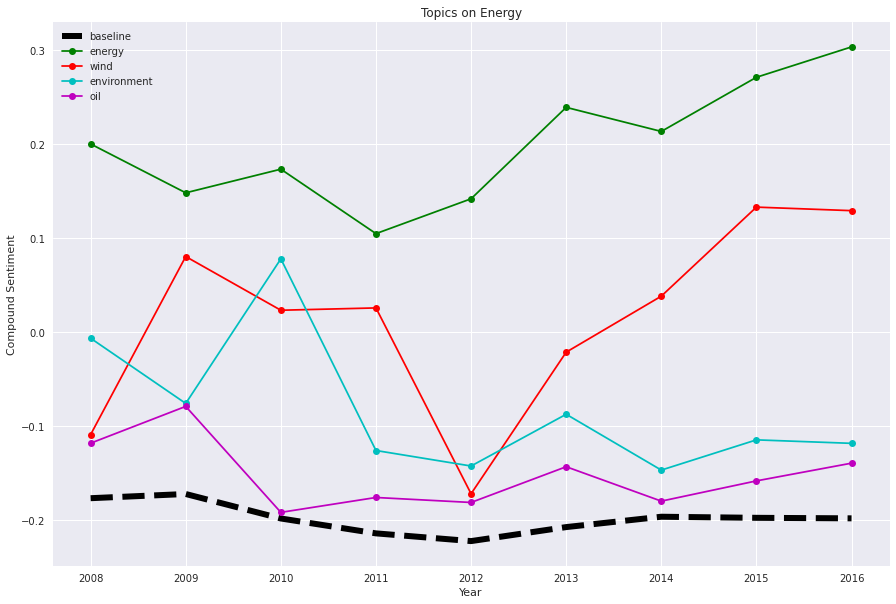

In [89]:
topics = ['baseline','energy','wind','environment','oil']
title = 'Topics on Energy'
plot_sentiment_pipeline(topics, title=title)

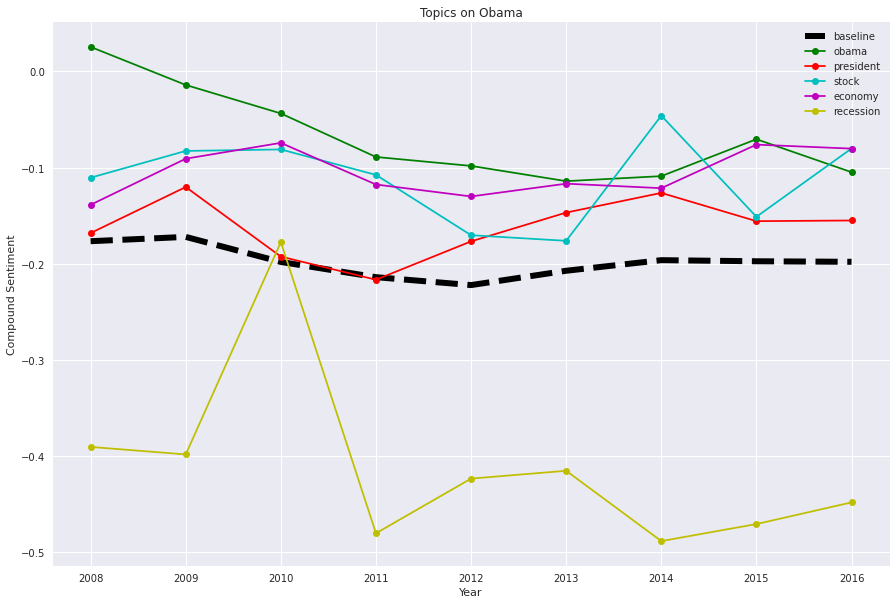

In [102]:
topics = ['baseline','obama','president','stock','economy','recession']
title = 'Topics on Obama'
plot_sentiment_pipeline(topics, title=title)

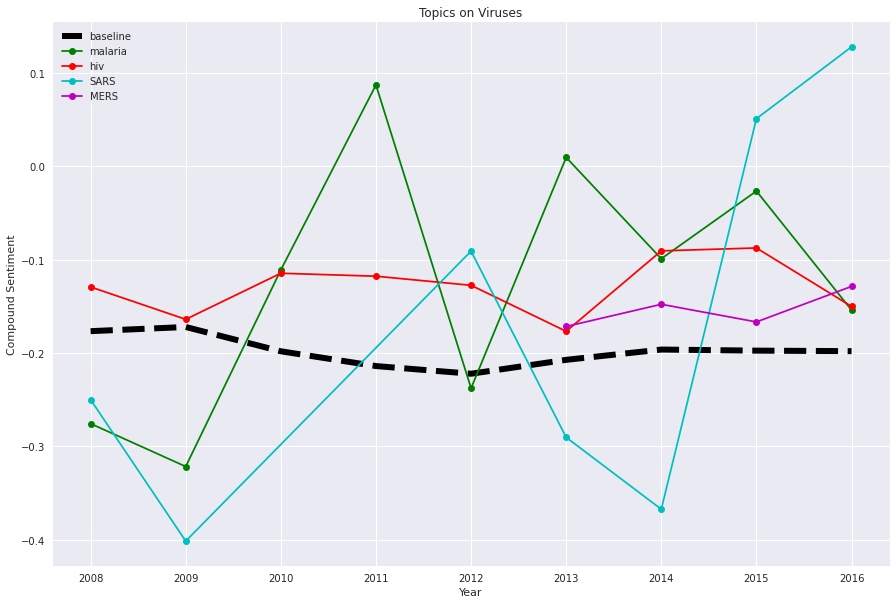

In [109]:
topics = ['baseline','malaria','hiv','SARS','MERS']
title = 'Topics on Viruses'
plot_sentiment_pipeline(topics, title=title)

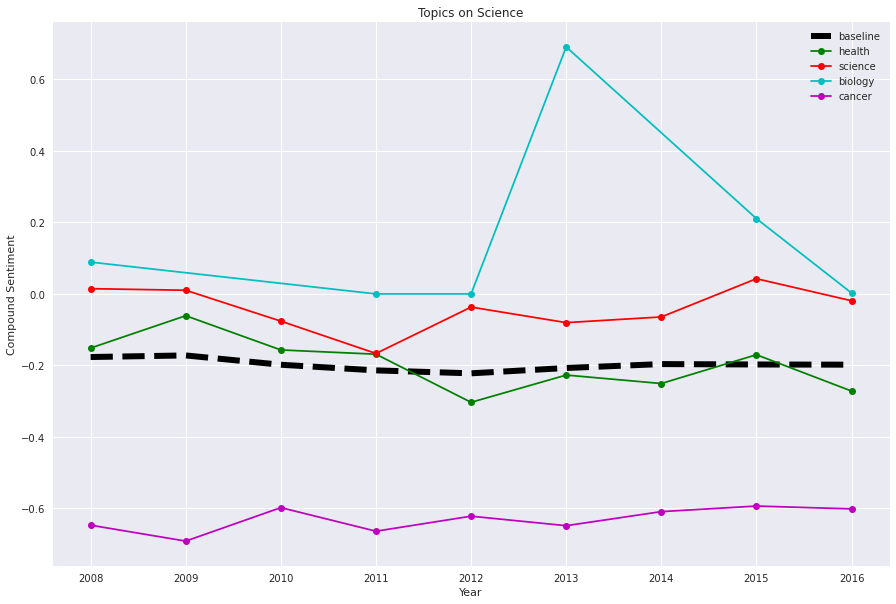

In [117]:
topics = ['baseline','health','science','biology','cancer']
title = 'Topics on Science'
plot_sentiment_pipeline(topics, title=title)

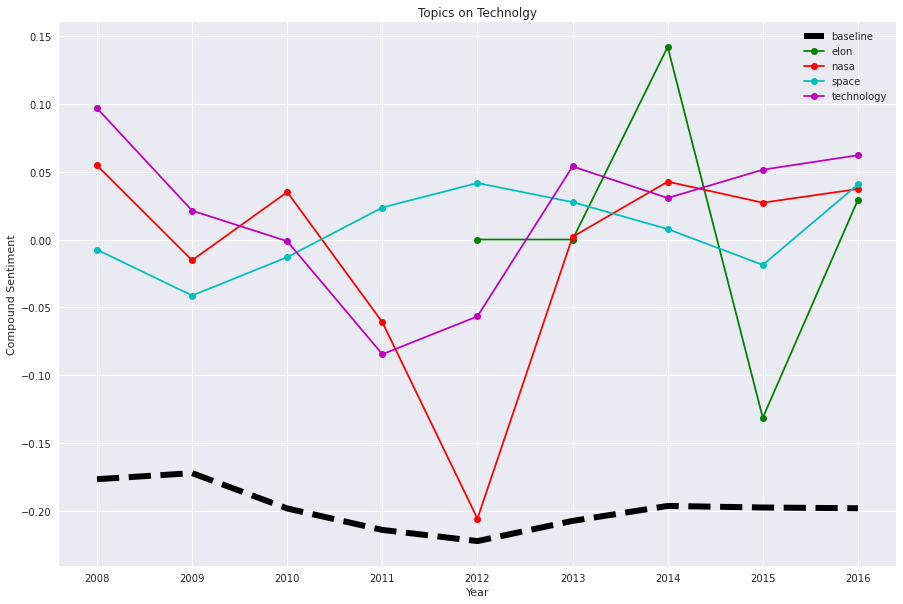

In [121]:
topics = ['baseline','elon','nasa','space','technology']
title = 'Topics on Technolgy'
plot_sentiment_pipeline(topics, title=title)

In [135]:
def plot_author_post_sentiment(authors, col='compound', title=''):
    dfs = []
    for author in authors:
        if author == 'baseline':
            temp_df = df.groupby(df.date_created.dt.year).agg({col:'mean'})
            temp_df.reset_index(drop=False, inplace=True)
            dfs.append(temp_df)
        else:
            temp_df = df[df['author'] == author].groupby(df.date_created.dt.year).agg({col:'mean'})
            temp_df.reset_index(drop=False, inplace=True)
            dfs.append(temp_df)
    
    fig = plt.figure(figsize=(15,10))
    for i,frame in enumerate(dfs):
        if authors[i] == 'baseline':
            plt.plot(frame['date_created'], frame[col], 'k--', linewidth=6, label=authors[i])
        else:
            plt.plot(frame['date_created'], frame[col], LINECOLOR_CYCLE[i], label=authors[i])
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Compound Sentiment")
    plt.title(title)

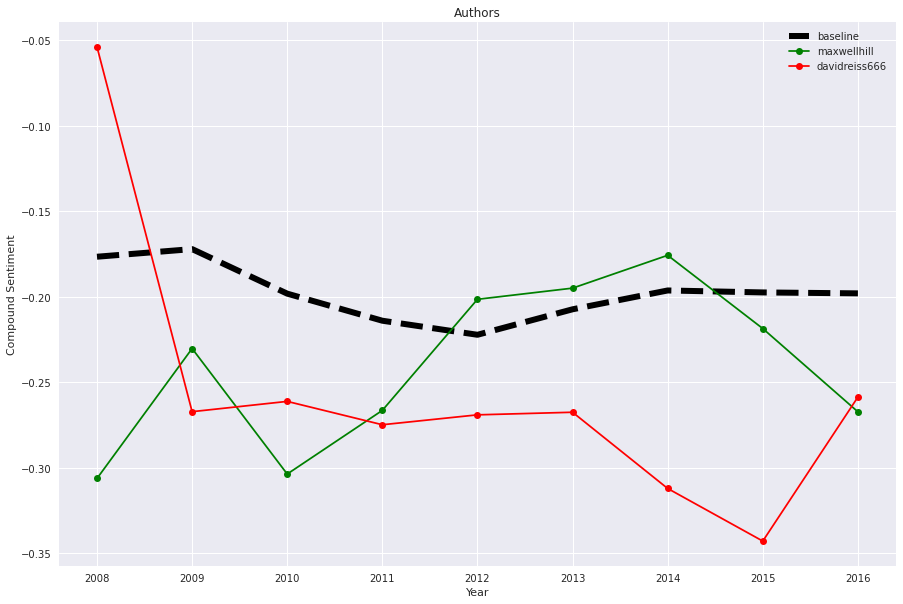

In [136]:
authors = ['baseline','maxwellhill','davidreiss666']
title = 'Authors'
plot_author_post_sentiment(authors, title=title)

## 4.4 Discussion <a name="section44"></a>

# 5.0 Conclusion <a name="section5"></a>

# 6.0 Appendix <a name="section6"></a>

## A: SpaCy Language Detection <a name="sectionA"></a>

I noticed from [Section 2.2](#section22) that there are some non-English titles. I tried a several things to translate the titles to English, but in the end I was not too successful.

I first tried using the `googletrans` package, however, it seemed to produce the error:

> 'NoneType' object has no attribute 'group'

I was not able to find a simple solution for this, but I found another package - `google_trans_new` - that did seem to work ([documentation here](https://github.com/lushan88a/google_trans_new)). However, I ran into another error! It seemed I had too many requests:

> 429 (Too Many Requests) from TTS API. Probable cause: Unknown

My next solution was to only translate the titles that were not English - there are plenty of language detection packages out there (`langdetect` is not very accurate on titles with fewer words), but I ended up using the `SpaCy` language detector after following [this code](https://stackoverflow.com/questions/66712753/how-to-use-languagedetector-from-spacy-langdetect-package). Unfortunately, I ran into the same '429 (Too Many Requests)' error. I haven't been able to debug this entirely, but in the future, I would like to solve this to get more accurate text processing for this report.

In [ ]:
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [ ]:
# text = '何謂標靶治療？ - 癌症 腫瘤 - Yahoo!奇摩部落格'

text = 'Hello world'
doc = nlp(text)
print(doc._.language.get('language'))

In [ ]:
df[df['title'] == '何謂標靶治療？ - 癌症 腫瘤 - Yahoo!奇摩部落格']

In [ ]:
## Took too long to run to count number of non-english titles

# count = 0
# for title in df.title:
#     doc = nlp(title)
#     if doc._.language.get('language') != 'en' and len(title.split()) > 3:
#         count += 1
# count

In [ ]:
def translate_to_english(x):
    doc = nlp(x)
    if doc._.language.get('language') != 'en':
        return translator.translate(x, lang_tgt='en')
    return x

# df['title'] = df['title'].apply(translate_to_english)

## B: Regexp Tokenizer Examples <a name="sectionB"></a>

In [ ]:
# Step 1.1: example regexp cases

# define new tokenizer
test = nltk.RegexpTokenizer(generic_re)

# test strings
test_remove = "economy: !!! .... \x07illegal"
test_dollar = "$1,000,000 $1m $17.5billion $125/each! $16-billion-a-year  $13(£8) $100+m/year"
test_hashred = "(#syria) #48kmarch: /r/legalnews" 

# they work!
print(test.tokenize(test_remove))
print(test.tokenize(test_dollar))
print(test.tokenize(test_hashred))

## C: Author Activity <a name="sectionC"></a>

In [386]:
import calendar

def author_activity(author):
    # filter by author name
    temp = df.filter(items=['up_votes','author'])[df['author'] == author]
    
    # create new columns to groupby
    temp['year'] = temp.date_created.dt.year
    temp['month'] = temp.date_created.dt.month
    temp['month'] = temp['month'].apply(lambda x: calendar.month_abbr[x])
    
    
    # aggregate
    temp = temp.groupby(['year', 'month'])\
               .agg({'up_votes':'sum','author':'count'})\
               .rename(columns={'author':author[0:3]+'_posts', 'up_votes':author[0:3]+'_votes'})
    
    return temp

In [387]:
auth1 = 'davidreiss666' 
auth2 = 'maxwellhill'

auth1_act = author_activity(auth1)
auth2_act = author_activity(auth2)

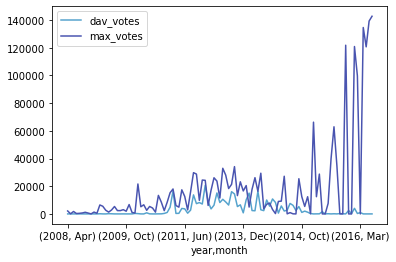

In [388]:
df_likes = pd.concat([auth1_act.iloc[:,0], auth2_act.iloc[:,0]], axis=1).fillna(0)
df_likes.plot()

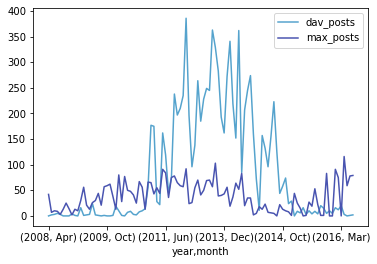

In [389]:
df_posts = pd.concat([auth1_act.iloc[:,1], auth2_act.iloc[:,1]], axis=1).fillna(0)
df_posts.plot()

## D: Most liked posts <a name="sectionD"></a>

In [ ]:
most_liked_posts = df.groupby(['title'])\
    .agg({'up_votes':'sum'})\
    .sort_values(by='up_votes', ascending = False)\
    .head(5)

most_liked_posts

**Observations:**
- The **maximum number of likes** for one post is **21,253** for a science-related article.
- Other high-trafficing posts seem to be about politics and violence (seems about right...).

## E: Adult Content <a name="sectionE"></a>

In [ ]:
adult_counts = df['over_18'].value_counts()
adult_counts

In [ ]:
print(f'NSFW posts are {100 * adult_counts[1]/df.shape[0]:.2f}% of the dataset')

In [ ]:
ax = sns.boxplot(x="over_18", y="up_votes", data=df)
ax.set_yscale("log")

In [ ]:
df[df['over_18'] == True]\
    .sort_values(by=['up_votes'], ascending = False)\
    .head(5)

**Observations:**
- Even though NSFW articles account for only 0.06% of the posts in this dataset, the have a higher average number of upvotes than SFW articles.

## F: Word Clouds for 2008-2012 and 2013-2016

In [ ]:
mask_08_12 = (df.date_created.dt.year >= 2008) & (df.date_created.dt.year <= 2012)
tokens_08_12 = df[mask_08_12].key_words.values.tolist()
tokens_08_12 = list(itertools.chain.from_iterable(tokens_08_12))
print(f'Between 2008 and 2012 there are {len(tokens_08_12)} key words')

mask_13_16 = (df.date_created.dt.year >= 2013) & (df.date_created.dt.year <= 2016)
tokens_13_16 = df[mask_13_16].key_words.values.tolist()
tokens_13_16 = list(itertools.chain.from_iterable(tokens_13_16))
print(f'Between 2013 and 2016 there are {len(tokens_13_16)} key words')

In [ ]:
title = "Wordcloud between 2008 and 2011"
wordcloud(tokens_08_12, title)

In [ ]:
title = "Wordcloud between 2013 and 2016"
wordcloud(tokens_13_16, title)